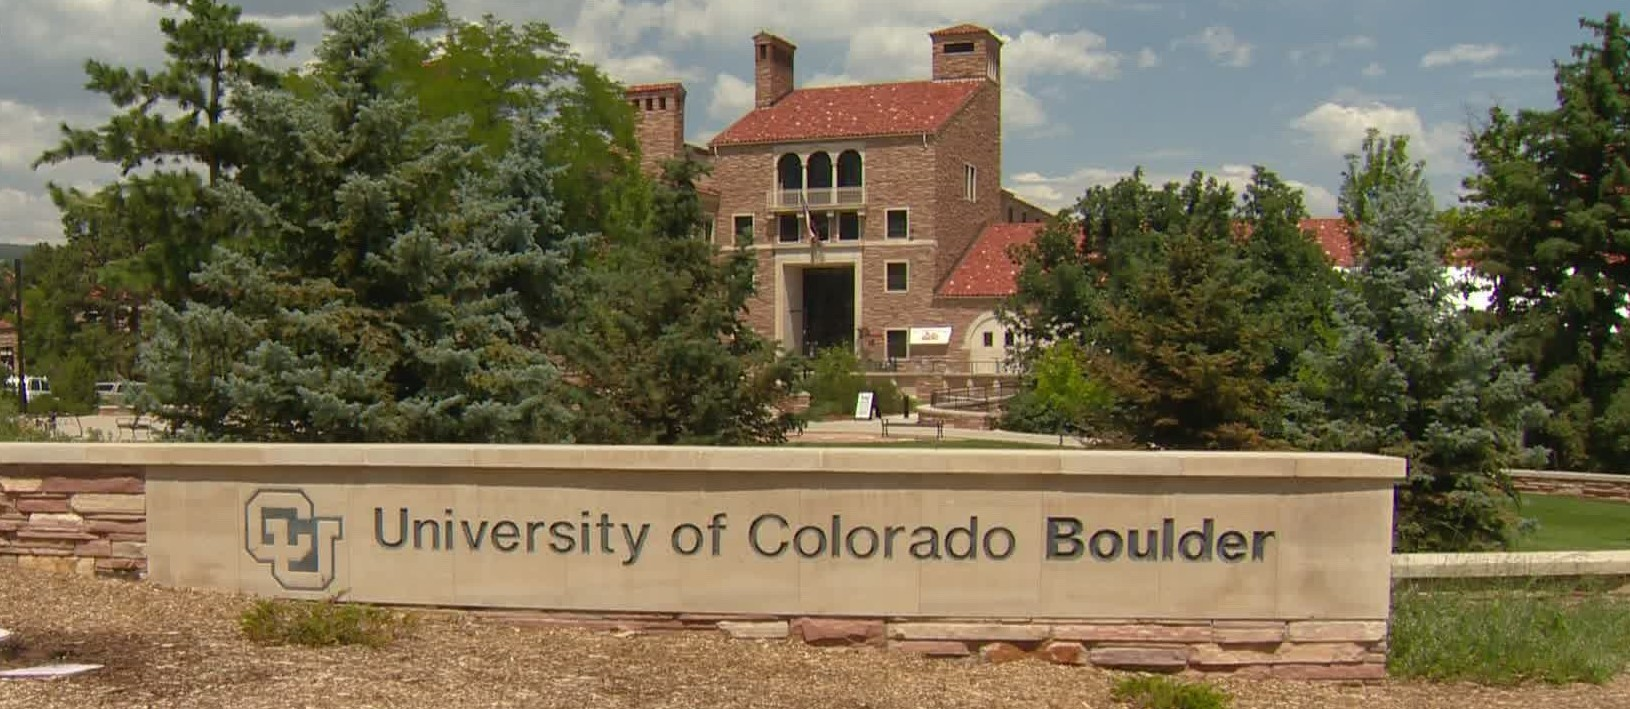

# Topic

This jupyter notebook is a project of the University of Colorado Boulder Master of Science in Data Science course DTSA-5511 - Introduction to Deep Learning.

I will compare different technics to solfe the Kaggle NLP "Getting Started" competition. Details about the competition and dataset could be found here: https://www.kaggle.com/competitions/nlp-getting-started/overview

This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 

I will build a Recurrent Neural Network (RNN) and compare the performance with a Random Forrest Classifier (RF). Goal is to identify Twitter Tweets which are about emergencys or disasters. Because Twitter is used by many people to inform in real time monitoring could help to identify fast emergencies.

## Data
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here: https://www.figure-eight.com/data-for-everyone/.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

The final test and train data could be found at [Kaggle competition page](https://www.kaggle.com/competitions/nlp-getting-started/data)

## Importing libraries

In [120]:
import pandas as pd
import numpy as np

# for performace patch
from sklearnex import patch_sklearn
patch_sklearn() # withe larger no of trees kernel dies
 
# disable  patching
#from sklearnex import unpatch_sklearn
#unpatch_sklearn()

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

from time import time # to messure running time

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier # Load random forest classifier 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

import itertools # For iteration over found categories and assign best match

import os

# set Kaggle API for download and submission
from kaggle.api.kaggle_api_extended import KaggleApi

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Extracting word features and Exploratory Data Analysis (EDA)

## Download data

I downloaded the data locally and saved it into my workdir of the project. 

In [123]:
# User and API key is stored in config
import config

# set user and API key
os.environ['KAGGLE_USERNAME'] = config.KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = config.KAGGLE_KEY

api = KaggleApi()
api.authenticate()

In [30]:
# Download competition files in data directory
api.competition_download_files("nlp-getting-started", path="data")

# unzip files
!unzip -d data "./data/nlp-getting-started.zip"
#!rm "./data/nlp-getting-started.zip"

Archive:  ./data/nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


## Importing data, cleaning and analysis

### Import data and get first overview


In [2]:
df_train = pd.read_csv('./data/train.csv', index_col='id')
df_test  = pd.read_csv('./data/test.csv', index_col='id')
df_subm = pd.read_csv("./data/sample_submission.csv")#, index_col='ArticleId')

In [3]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 7613
Total number of columns: 4


In [4]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total number of rows:', df_test_row_count)
print('Total number of columns:', df_test_column_count)

Total number of rows: 3263
Total number of columns: 3


In [5]:
df_subm_row_count, df_subm_column_count=df_subm.shape
print('Total number of rows:', df_subm_row_count)
print('Total number of columns:', df_subm_column_count)

Total number of rows: 3263
Total number of columns: 2


In [6]:
df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_subm.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [9]:
target_class = pd.DataFrame({'count': df_train.target.value_counts(),
                             'percentage': df_train['target'].value_counts() / df_train.shape[0] * 100
})
target_class

,count,percentage
0,4342,57.034021
1,3271,42.965979


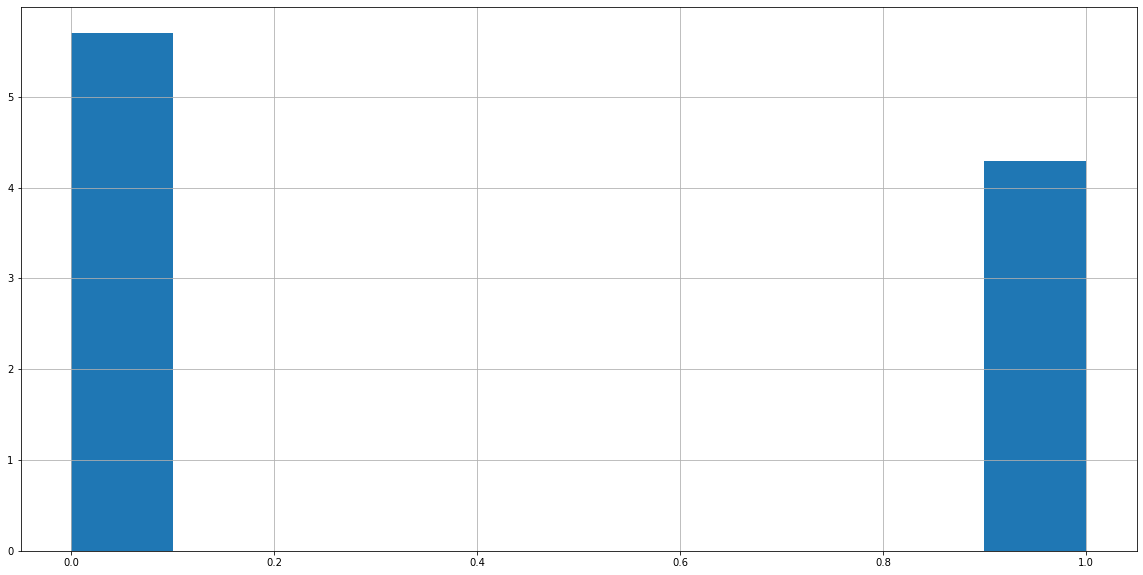

In [10]:
# increase size of plots
plt.rcParams["figure.figsize"] = (20,10)

# create a histogramm
plt.hist(df_train.target, density=True)#, orientation='horizontal')
plt.grid(True)
plt.show()



Source data consits of of three files

- train.csv
- test.csv
- sample_submission.csv

Train data contains 7613 rows and 4 columns. "id" with an ID of the tweet, "text" with the text of the tweet, some dataset also include keyword and location data and "target" with the ground truth 0 for non emergencvy or 1 for emergency.

Distirbution is 57% non emergency and 43% emergency tweets

Test data contains 3263 rows and 3 columns. It alsco contains the "id" and "text" but no targed value.

sample_submission.csv is just a sample file how the Kaggle submission should look like and consits of 3263 rows and 2 columns, one with the id and and one for the predicted target.

### Further analysis and cleaning

In [11]:
# Verify size and data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [12]:
# check distribution and min max values
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613.0,NaN,NaN,NaN,0.42966,0.49506,0.0,0.0,0.0,1.0,1.0


In [13]:
# check distribution and min max values
df_test.describe(include='all').T

,count,unique,top,freq
keyword,3237,221,deluged,23
location,2158,1602,New York,38
text,3263,3243,11-Year-Old Boy Charged With Manslaughter of T...,3


In [14]:
# check maximum length 
max(df_train.text.apply(len))

157

In [15]:
# check maximum length 
max(df_test.text.apply(len))

151

### Check for missing values

In [16]:
df_train.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [17]:
sum(df_train.isna().sum())

2594

In [18]:
df_test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [19]:
sum(df_train.isna().sum())

2594

We have a NA values in keyword and location but no NA in the text column of test or train set.

### Check for unique values

In [20]:
print ("Unique values are:\n",df_train.nunique())
print ("Max unique values are:\n",max(df_train.nunique()))

Unique values are:
 keyword      221
location    3341
text        7503
target         2
dtype: int64
Max unique values are:
 7503


Dataset has 2 taget unique values as we already know. We have 7613 datapoint in train set. Text has 7503 unique values so there must be some duplicates in "text".

### Check for duplicate entries

In [21]:
# check for duplicate entries
print("duplicate entries in trainset:",df_train.duplicated(subset=['text']).sum())
print("duplicate entries in testset:",df_test.duplicated(subset=['text']).sum())


duplicate entries in trainset: 110
duplicate entries in testset: 20


Train as well as testset has duplicate entries. In testset we will keep these entries for correct prediction. In trainset we could drop the duplicate entries because they will give us no additional information.

In [22]:
# drop duplicate entries in train set
df_train = df_train.drop_duplicates(subset=['text'])

In [23]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 7503
Total number of columns: 4


After data cleaning we are left with 7503 unique rows in trainset with one taget Category and one Text column. We have no NA or missing values in text.

### Create dataframes for ground truth (y) and features (X)

In [24]:
#Defining X and y
X = df_train.drop(['target'], axis=1)
y = df_train['target']

### Split dataset for training and internal testing

In [25]:
# creating dataset split for prediction

X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (6002, 3)
y_train: (6002,)
X_test: (1501, 3)
y_test: (1501,)


## Word embedding



I decided to use Bag of Words representation as embedding. Details could be found on sklearn website: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

There I found also some examples and demo code I used as base for building models below.

I used the TfidfVectorizer without english stop words and minimum and maximum accurence. In a nutshell the input string with text is convertet all into lowercase and all special characters are removed. Blank is used as seperater between the words. Than all stop words (words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text) are removed.

This is the input text for the tokenizing. In tokenizing a integer is assigned ti every unique word. Occurrences of words/token is counted per String and the weight are at the end normalized.

This matrix representation of the input strings is now used to feed and train the matrix factorization model. The model predicts probabilities for in this case 5 classes. Class with highest probability is choosen as target.

In [26]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,    #ignore terms that have a document frequency strictly higher than the given threshold 
    min_df=10,        #ignore terms that have a document frequency strictly lower than the given threshold#
#    max_features=10, #n_features, 
#    analyzer="char_wb", # {‘word’, ‘char’, ‘char_wb’} or callable, default=’wor
    stop_words="english"
)

# Vectorize words
t0 = time()
X_train_tf = tfidf_vectorizer.fit_transform(df_train["text"])


print("Vectorization time:", time() - t0)

Extracting tf-idf features for NMF...
Vectorization time: 0.08502006530761719


## Building and training matrix factorization model.


In [114]:
# Helper function to plot most frequent words. Adoptet from a function I found in the sklearn dokumentation

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [109]:
# Helper function to find best matching labels sequence
def label_permute_compare(ytdf,yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """

    labels = np.unique(ytdf)
    acc = list()
    permutations = list(itertools.permutations(range(n)))
    for permut in permutations:
        acc.append(accuracy_score(yp.replace(labels, permut), ytdf))
    return permutations[acc.index(max(acc))], max(acc)


In [110]:
n_components = 2  # These are the 5 classes we try to predict


#create dataframe for accuracy and parameter
paraacc = pd.DataFrame(columns=['acc', 'labelorder', 'alpha', 'l1_ratio'])

# take start time
t0 = time()
idx = 0

# loop over some parameter for tuning on training data
for alpha in [0, 0.01,0.05,0.1,0.25,0.5,0.75,1]:
    for l1_ratio in [0, 0.01,0.05,0.1,0.25,0.5,0.75,1]:
        nmf = NMF(
            n_components=n_components,
            random_state=1,
            alpha=alpha,
            l1_ratio=l1_ratio
        ).fit(X_train_tf)

        if nmf.components_.any() != 0:
            # create prediction probabilities
            y_predict_prob = nmf.transform(X_train_tf)

            # index with highest probability is our predicted class
            y_predict = np.argmax(y_predict_prob, axis=1)

            # create dataframe
            y_predictdf = pd.DataFrame(y_predict)

            # check best labelorder
            labelorder, acc = label_permute_compare(y, y_predictdf)
            print("Accuracy:",acc, "alpha:", alpha, "l1_ratio:",l1_ratio, "label order:", labelorder, )

            # save output in dataframe
            paraacc.loc[idx] = [acc, labelorder, alpha, l1_ratio]
            idx += 1

        
print("Parameter tuning done in %0.3fs." % (time() - t0))


Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0.01 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0.05 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0.1 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0.25 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0.5 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 0.75 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0 l1_ratio: 1 label order: (1, 0)
Accuracy: 0.6444089031054245 alpha: 0.01 l1_ratio: 0 label order: (1, 0)
Accuracy: 0.6442756230840997 alpha: 0.01 l1_ratio: 0.01 label order: (1, 0)
Accuracy: 0.6438757830201253 alpha: 0.01 l1_ratio: 0.05 label order: (1, 0)
Accuracy: 0.6436092229774757 alpha: 0.01 l1_ratio: 0.1 label order: (1, 0)
Accuracy: 0.642676262828202 alpha: 0.01 l1_ratio: 0.25 label order: (1, 0)
Accuracy: 0.6421431427429029 alpha: 0.01 l1_ratio

In [111]:
# get best parameter
paraacc[paraacc["acc"]==max(paraacc.acc)]

,acc,labelorder,alpha,l1_ratio
0,0.644409,"(1, 0)",0.00,0.00
1,0.644409,"(1, 0)",0.00,0.01
2,0.644409,"(1, 0)",0.00,0.05
3,0.644409,"(1, 0)",0.00,0.10
4,0.644409,"(1, 0)",0.00,0.25
5,0.644409,"(1, 0)",0.00,0.50
6,0.644409,"(1, 0)",0.00,0.75
7,0.644409,"(1, 0)",0.00,1.00
8,0.644409,"(1, 0)",0.01,0.00


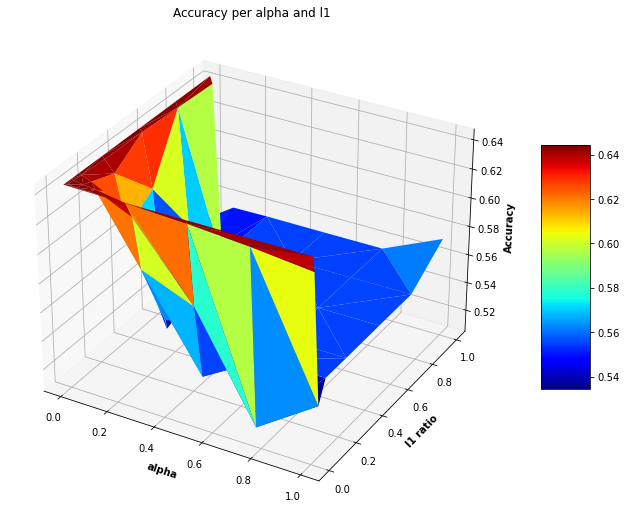

In [112]:
# Plot accuracy per alpha and l1

# Creating color map
my_cmap = plt.get_cmap('jet')

fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(paraacc.alpha, paraacc.l1_ratio, paraacc.acc, cmap = my_cmap, linewidth=0.5)

fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Accuracy per alpha and l1')

# Adding labels
ax.set_xlabel('alpha', fontweight ='bold')
ax.set_ylabel('l1 ratio', fontweight ='bold')
ax.set_zlabel('Accuracy', fontweight ='bold')

plt.show() 

done in 0.028s.


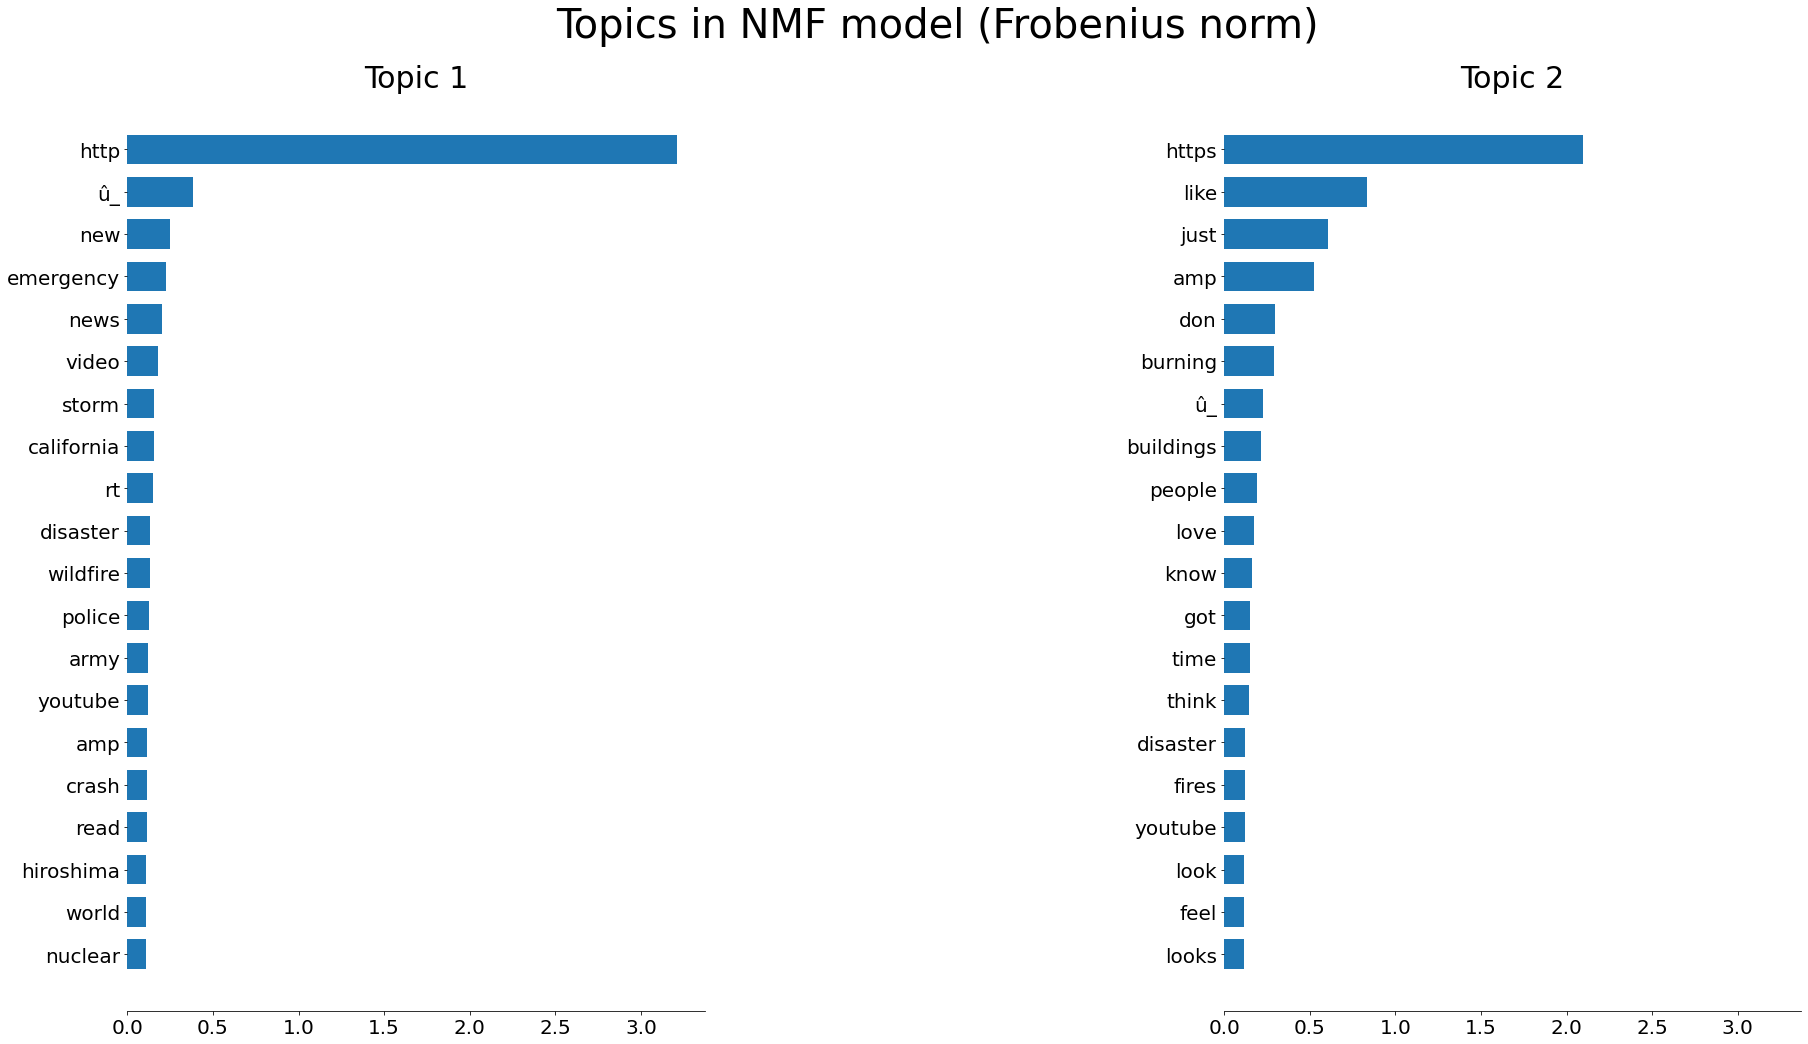

In [115]:
n_top_words = 20

# Fit the NMF model

t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=0, l1_ratio=0).fit(X_train_tf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [116]:
# create prediction probabilities
y_predict_prob = nmf.transform(X_train_tf)
print(y_predict_prob)

# index with highest probability is our predicted class
y_predict = np.argmax(y_predict_prob, axis=1)


[[0.00318422 0.00299141]
 [0.00526261 0.00430207]
 [0.00282697 0.00341545]
 ...
 [0.03821869 0.00064508]
 [0.03644405 0.        ]
 [0.05378786 0.        ]]


In [117]:
# create dataframe
y_predictdf = pd.DataFrame(y_predict)

# check best labelorder
labelorder, acc = label_permute_compare(y, y_predictdf)
print("Best label order is:", labelorder, "With Accuracy:",acc)

# assign best labelorder to prediction
y_predictdf = y_predictdf.replace(np.unique(y_predictdf), labelorder)

Best label order is: (1, 0) With Accuracy: 0.6444089031054245


[[2598 1707]
 [ 961 2237]]


<AxesSubplot:>

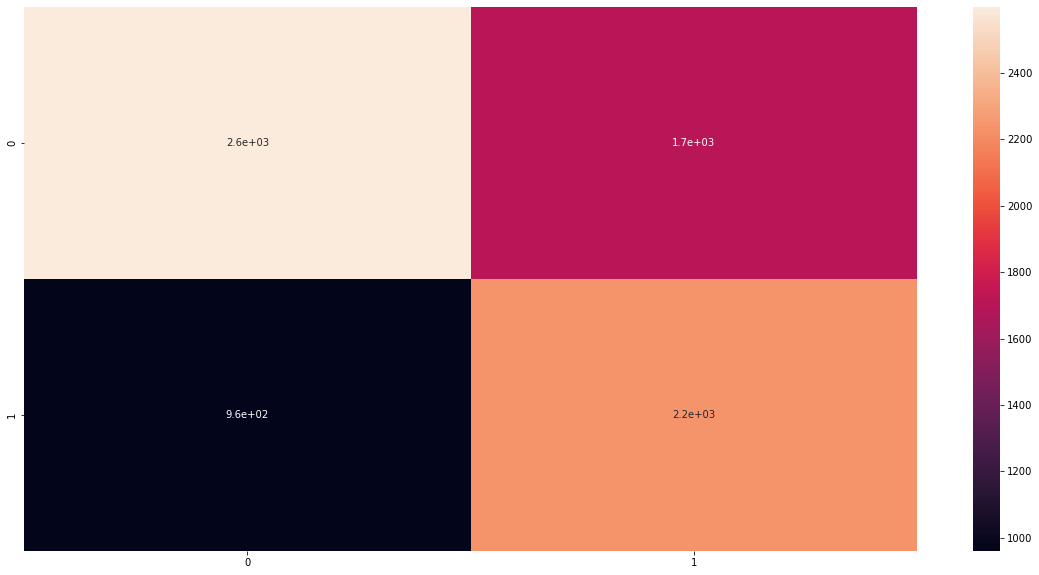

In [118]:
print(confusion_matrix(y, y_predictdf))

cm = pd.DataFrame(confusion_matrix(y, y_predictdf))
sns.heatmap(cm, annot=True)

### Final prediction on Kaggle Testset

In [126]:
# Vectorize words final testset
df_test_tf = tfidf_vectorizer.transform(df_test["text"])

# Make final prediction 
y_submit_prob = nmf.transform(df_test_tf)

# index with highest probability is our predicted class
y_submit = np.argmax(y_submit_prob, axis=1)

# create dataframe
y_submit = pd.DataFrame(y_submit)

# assign best labelorder to prediction
y_submit = y_submit.replace(np.unique(y_submit), labelorder)

## Prepare submission

In [154]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["target"]

y_submit.head()

,target
0,0
1,1
2,1
3,0
4,1


In [155]:
# Create submission

# Add "ArticleId" from testset
submission=pd.concat([df_subm['id'],y_submit],axis=1)

print(submission.head())

# Write submission file
submission.to_csv("./data/submission.csv",index=False)

   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1


In [157]:
api.competition_submit(file_name = "./data/submission.csv",
                       message="matrix factorization",
                       competition = "nlp-getting-started")

""" submit a competition!

          Parameters
          ==========
          file_name: the competition metadata file
          message: the submission description
          competition: the competition name
          quiet: suppress verbose output (default is False)
"""



100%|██████████| 25.4k/25.4k [00:02<00:00, 10.8kB/s]


' submit a competition!\n\n          Parameters\n          ==========\n          file_name: the competition metadata file\n          message: the submission description\n          competition: the competition name\n          quiet: suppress verbose output (default is False)\n'

## Compare with Random Forest Classifier

Next approach is to use a random forrest classifier.

### Model selection

To find propper parameters I used parameter tuning via GridSearch with cross validation. I tried different combinations for the number of trees, the minimum sample split size, minimum number of sample leafgs and ccp alpha for pruning.

If you run the notebook please be aware that this will take a very long time dependingn on your hardware.

I did this comparisons and parameter tuning iterative and in severals runs. Therfore I have no homogenius output or nice plots. I summarized the results below which lead to the final model.

Beside grid search I also tried differend values for out of bag and maximum depth. Result was default values without limiting the depth of the tree or using out of bag has highes accuray in this case.

In [120]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(500,2001,500)), 'min_samples_split':list(range(2,11,2)), "min_samples_leaf":list(range(1,11,2))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)


grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapse

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 co

[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.4s
[Parallel

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finishe

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:  

[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.3

[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      |

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | ela

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elaps

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elaps

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    

[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.5s finishe

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    

[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks     

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed: 

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1,
                                              warm_start=True),
             param_grid={'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [500, 1000, 1500, 2000]})

In [121]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.7795732133933034
Best parameters: {'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1500}


In [138]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(1500,2501,500))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    min_samples_split = 2,
    min_samples_leaf = 3,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    3.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(min_samples_leaf=3, n_jobs=-1,
                                              oob_score=True, random_state=42,
                                              verbose=1, warm_start=True),
             param_grid={'n_estimators': [1500, 2000, 2500]})

In [139]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.7795732133933034
Best parameters: {'n_estimators': 1500}


In [140]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.1,1.1,0.1))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 3,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              min_samples_leaf=3,
                                              n_estimators=500, n_jobs=-1,
                                              random_state=42, verbose=1,
                                              warm_start=True),
             param_grid={'ccp_alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                       0.6, 0.7000000000000001, 0.8, 0.9,
                                       1.0]})

In [141]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.5716427619523571
Best parameters: {'ccp_alpha': 0.1}


In [143]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.logspace(np.log(0.0005), np.log(0.005), 10))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 3,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  

[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elaps

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              min_samples_leaf=3,
                                              n_estimators=500, n_jobs=-1,
                                              random_state=42, verbose=1,
                                              warm_start=True),
             param_grid={'ccp_alpha': [2.5066721763645345e-08,
                                       4.517938642887828e-08,
                                       8.142975285464993e-08,
                                       1.467661509836486e-07,
                                       2.645261998154906e-07,
                                       4.767728111682978e-07,
                                       8.593187125807323e-07,
                                       1.5488061242039796e-06,
                                       2.791514225458448e-06,
                                       5.031328033353388e-06]})

In [144]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.7742417124770947
Best parameters: {'ccp_alpha': 2.5066721763645345e-08}


In [146]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.000001, 0.00001, 0.000001))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 3,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              min_samples_leaf=3,
                                              n_estimators=500, n_jobs=-1,
                                              random_state=42, verbose=1,
                                              warm_start=True),
             param_grid={'ccp_alpha': [1e-06, 2e-06, 3e-06, 4e-06,
                                       4.9999999999999996e-06,
                                       5.999999999999999e-06, 7e-06, 8e-06,
                                       9e-06]})

In [147]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.7742417124770947
Best parameters: {'ccp_alpha': 1e-06}


### Results of Random forrest parameter tuning

Summary of parameter tuning was that a ccp_alpha of 0, min_samples_leaf of 3, min_samples_split of 2 and 1500 trees will lead to the highest accuracy of the model.

### Final Model

In [149]:
#Create a final random forest Classifier
mrf = RandomForestClassifier(
    n_estimators=1500, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, 
    min_samples_split = 2,
    min_samples_leaf = 3,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=False, # For grid Search
    max_samples=None, # None = All 
    ccp_alpha=1*10**-6,    #Minimal Cost-Complexity Pruning
    verbose=1 # Enable massages during fit and predict (Level 2 shows every tree)
)

### final training on full data
After I selected the model with best performance I started training on full dataset. Remember I splited the dataset 80/20 for train and test before but for final training I use the full dataset and prediction is on the Kaggle testset.

In [150]:
t0_full = time() # Start time for training
    
# Train model with full dataset
mrf.fit(tfidf_vectorizer.transform(X["text"]), y)
    
# End time for training
rf_time_train_full=time() - t0_full

print('Training time', rf_time_train_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:    1.8s


Training time 2.686629056930542


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.2s finished


In [151]:
# Make prediction on testset
y_pred = mrf.predict(tfidf_vectorizer.transform(X_test["text"]))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished


Random Forrest Accuracy: 0.8867421718854097


<AxesSubplot:>

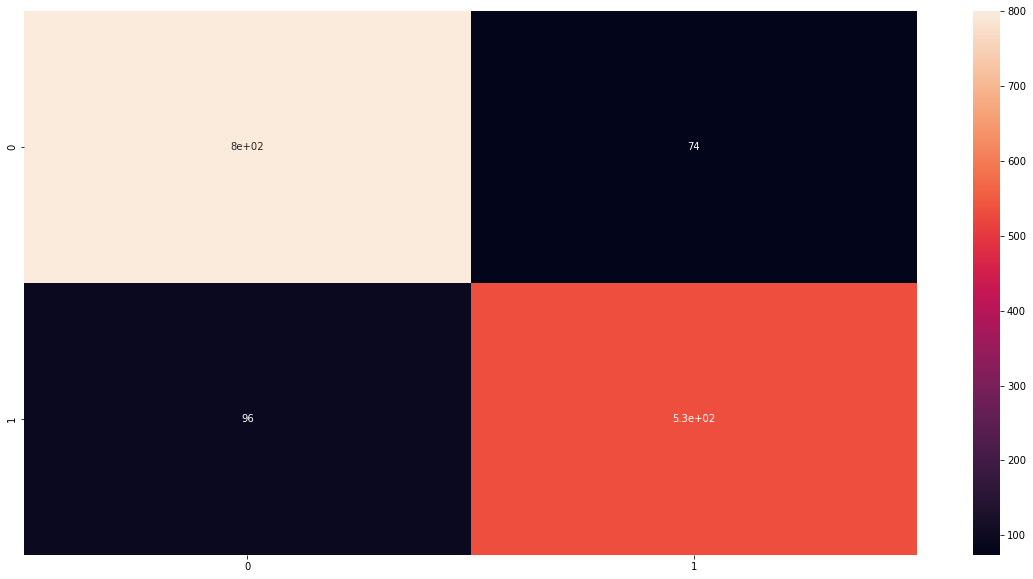

In [152]:
#Print Confusion Matrix
print("Random Forrest Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True)

In this case we have accuracy of 0.887 on the tetset and therefore also in confusion matrix. For the real testset on Kaggle I dont have the ground truth and therefore no cofusion matrix. Score was 0.77597.

### Final prediction on Kaggle Testset

In [153]:
# Make final prediction random forest
y_submit = mrf.predict(tfidf_vectorizer.transform(df_test["text"]))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.3s finished


## Prepare submission

In [154]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["target"]

y_submit.head()

,target
0,0
1,1
2,1
3,0
4,1


In [155]:
# Create submission

# Add "ArticleId" from testset
submission=pd.concat([df_subm['id'],y_submit],axis=1)

print(submission.head())

# Write submission file
submission.to_csv("./data/submission.csv",index=False)

   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1


In [157]:
api.competition_submit(file_name = "./data/submission.csv",
                       message="Random Forrest",
                       competition = "nlp-getting-started")

""" submit a competition!

          Parameters
          ==========
          file_name: the competition metadata file
          message: the submission description
          competition: the competition name
          quiet: suppress verbose output (default is False)
"""



100%|██████████| 25.4k/25.4k [00:02<00:00, 10.8kB/s]


' submit a competition!\n\n          Parameters\n          ==========\n          file_name: the competition metadata file\n          message: the submission description\n          competition: the competition name\n          quiet: suppress verbose output (default is False)\n'

## Compare with Recurrent Neural Network 

Next approach is to use a Recurrent Neural Network.

In [516]:
max_len = 127

vectorize_layer = tf.keras.layers.TextVectorization(
    # only lowercase and without punctuation
    standardize="lower_and_strip_punctuation",
    # Output integer indices, one per string token
    output_mode="int",
    # Always pad or truncate to exactly this many tokens
    output_sequence_length=max_len,
)

In [517]:
# for stop word removal
from gensim.parsing.preprocessing import remove_stopwords

# Call adapt(), which fits the TextVectorization layer to our text dataset.

# adapt vectorizer on full text including all train and test texts
vectorize_layer.adapt(df_train.text.append(df_test.text).apply(lambda x: remove_stopwords(x)))

In [518]:
X_train_vec = vectorize_layer(X_train.text)
X_train_vec = X_train_vec.numpy()

X_test_vec = vectorize_layer(X_test.text)
X_test_vec = X_test_vec.numpy()

In [519]:
# check how vectorized train set looks 
X_train_vec

array([[ 9638,    79,     3, ...,     0,     0,     0],
       [ 1495,    28,  4541, ...,     0,     0,     0],
       [13172,  1693,   290, ...,     0,     0,     0],
       ...,
       [27728,   242,  1236, ...,     0,     0,     0],
       [11757,   631,  1547, ...,     0,     0,     0],
       [ 1587,  1074,    67, ...,     0,     0,     0]], dtype=int64)

In [706]:
import tensorflow as tf

# Create tensorflow Model
tf.keras.regularizers.l2(l2=0.001)
#tf.keras.regularizers.l1(l1=0.001)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(7000, 128),   
    tf.keras.layers.GaussianNoise(0.4),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy'])
              #metrics=['BinaryAccuracy'])

model.build()
model.summary()

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_108 (Embedding)   (None, None, 128)         896000    
                                                                 
 gaussian_noise_13 (Gaussian  (None, None, 128)        0         
 Noise)                                                          
                                                                 
 dropout_363 (Dropout)       (None, None, 128)         0         
                                                                 
 bidirectional_162 (Bidirect  (None, None, 128)        98816     
 ional)                                                          
                                                                 
 dropout_364 (Dropout)       (None, None, 128)         0         
                                                                 
 bidirectional_163 (Bidirect  (None, None, 64)      

In [707]:
# fit Model on trainset, could also be used to continue training

model.fit(
    x = X_train_vec,
    y = y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test_vec, y_test)
    )

Epoch 1/10
47/47 [==============================] - 9s 89ms/step - loss: 0.6943 - accuracy: 0.5143 - val_loss: 0.6847 - val_accuracy: 0.5823
Epoch 2/10
47/47 [==============================] - 3s 65ms/step - loss: 0.6871 - accuracy: 0.5628 - val_loss: 0.6828 - val_accuracy: 0.5823
Epoch 3/10
47/47 [==============================] - 3s 67ms/step - loss: 0.6842 - accuracy: 0.5678 - val_loss: 0.6795 - val_accuracy: 0.5823
Epoch 4/10
47/47 [==============================] - 3s 67ms/step - loss: 0.6838 - accuracy: 0.5696 - val_loss: 0.6779 - val_accuracy: 0.5823
Epoch 5/10
47/47 [==============================] - 3s 65ms/step - loss: 0.6746 - accuracy: 0.5820 - val_loss: 0.6154 - val_accuracy: 0.7422
Epoch 6/10
47/47 [==============================] - 3s 66ms/step - loss: 0.6401 - accuracy: 0.6554 - val_loss: 0.5463 - val_accuracy: 0.7548
Epoch 7/10
47/47 [==============================] - 3s 66ms/step - loss: 0.5881 - accuracy: 0.7116 - val_loss: 0.5097 - val_accuracy: 0.7662
Epoch 8/10
47

In [708]:
training_loss = list(model.history.history['loss'])
val_loss = list(model.history.history['val_loss'])
training_acc = list(model.history.history['accuracy'])
val_acc = list(model.history.history['val_accuracy'])
epochs = len(training_loss)

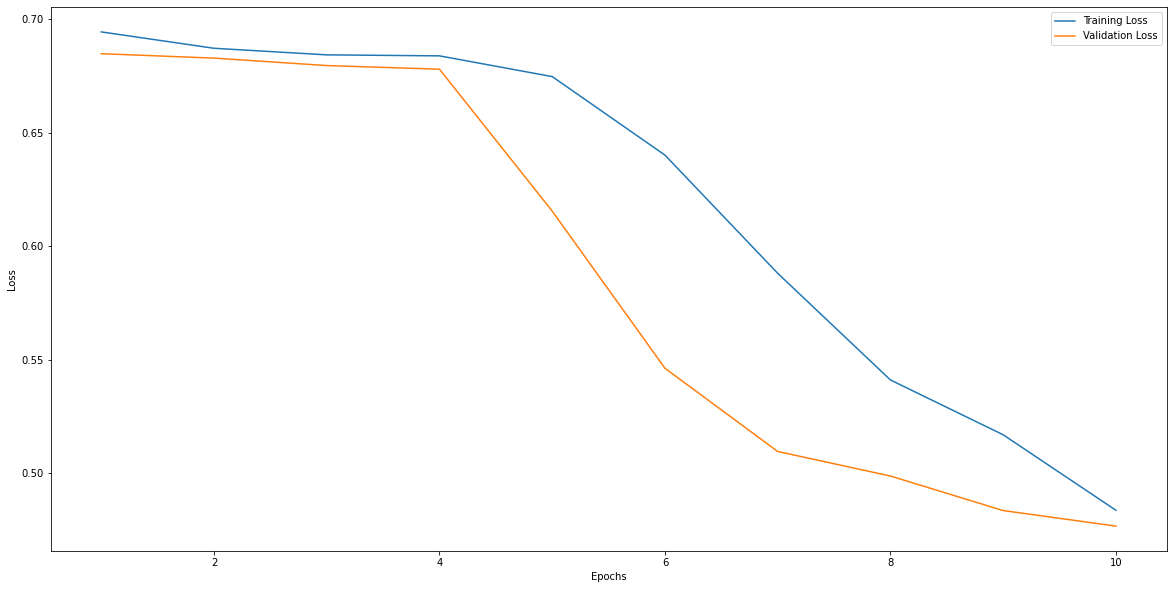

In [709]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.plot(list(range(1,epochs+1,1)), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

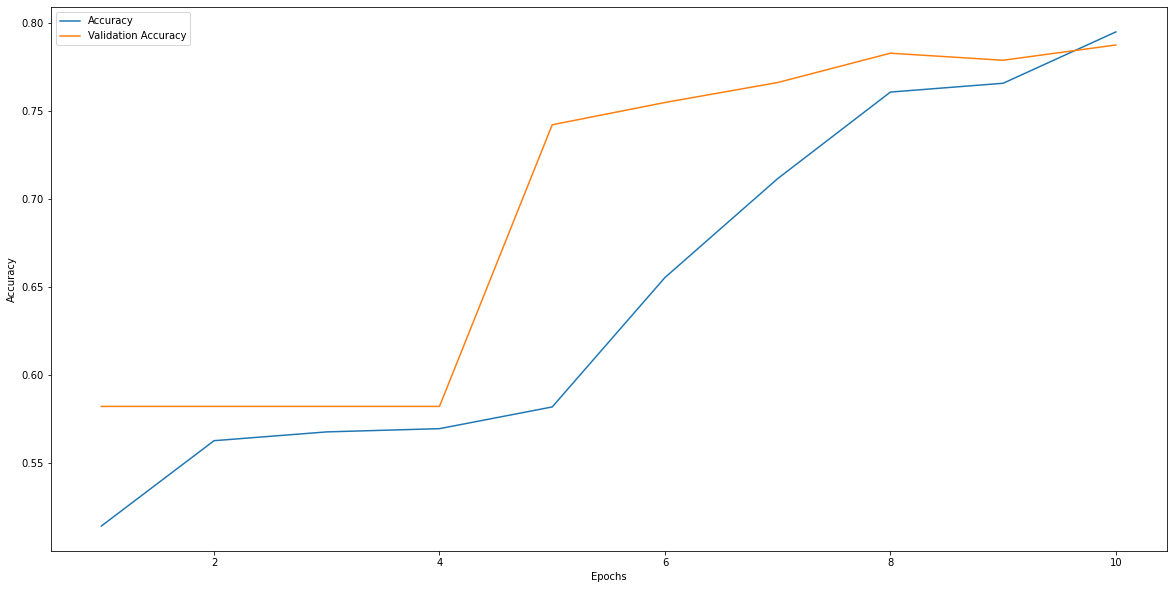

In [710]:
plt.plot(list(range(1,epochs+1,1)), training_acc, label='Accuracy')
plt.plot(list(range(1,epochs+1,1)), val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [719]:
# continue trainging
additional_epochs = 10

model.fit(
    x = X_train_vec,
    y = y_train,    
    epochs=epochs+additional_epochs,
    initial_epoch=epochs,
    batch_size=128,
    validation_data=(X_test_vec, y_test)
    )

Epoch 31/40
47/47 [==============================] - 3s 66ms/step - loss: 0.2911 - accuracy: 0.8869 - val_loss: 0.6768 - val_accuracy: 0.7915
Epoch 32/40
47/47 [==============================] - 3s 65ms/step - loss: 0.2865 - accuracy: 0.8919 - val_loss: 0.6781 - val_accuracy: 0.7915
Epoch 33/40
47/47 [==============================] - 3s 65ms/step - loss: 0.2767 - accuracy: 0.8950 - val_loss: 0.6940 - val_accuracy: 0.7941
Epoch 34/40
47/47 [==============================] - 3s 65ms/step - loss: 0.2695 - accuracy: 0.8977 - val_loss: 0.7394 - val_accuracy: 0.7935
Epoch 35/40
47/47 [==============================] - 3s 65ms/step - loss: 0.2716 - accuracy: 0.9009 - val_loss: 0.7556 - val_accuracy: 0.7941
Epoch 36/40
47/47 [==============================] - 3s 65ms/step - loss: 0.2694 - accuracy: 0.8962 - val_loss: 0.7766 - val_accuracy: 0.7881
Epoch 37/40
47/47 [==============================] - 3s 65ms/step - loss: 0.2658 - accuracy: 0.9010 - val_loss: 0.7404 - val_accuracy: 0.7921
Epoch 

In [720]:
training_loss.extend(list(model.history.history['loss']))
val_loss.extend(list(model.history.history['val_loss']))
training_acc.extend(list(model.history.history['accuracy']))
val_acc.extend(list(model.history.history['val_accuracy']))
epochs = len(training_loss)

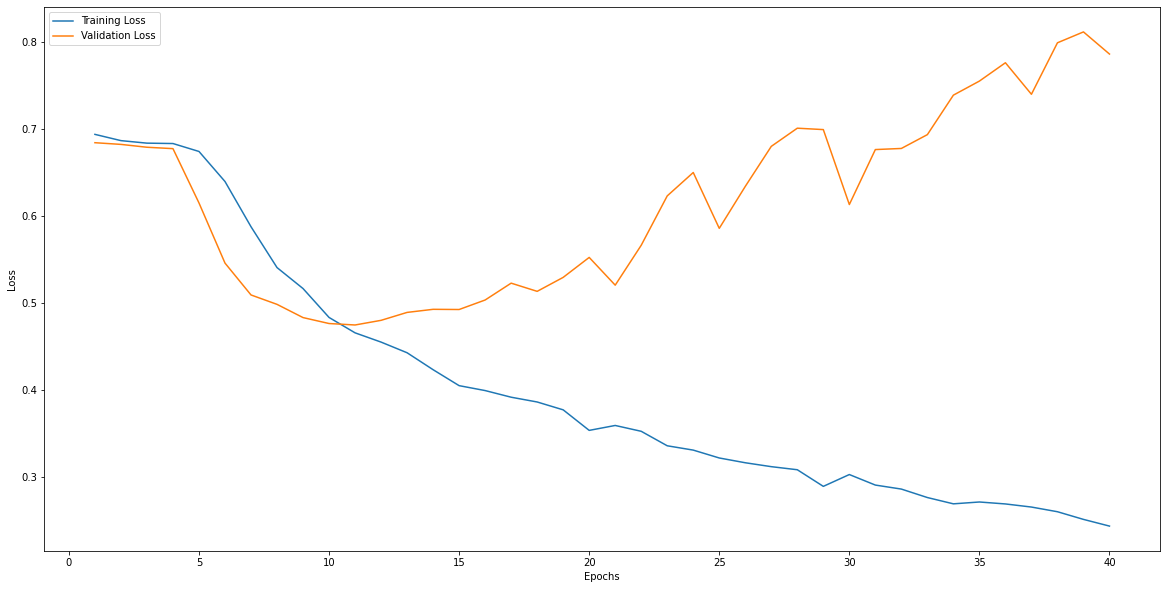

In [721]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.plot(list(range(1,epochs+1,1)), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

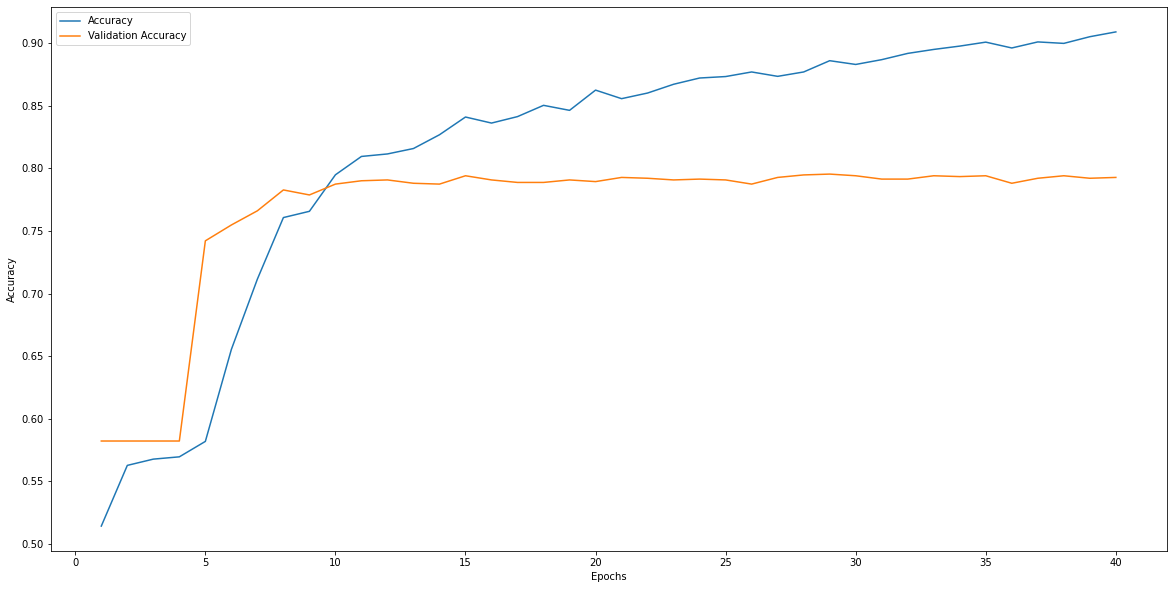

In [722]:
plt.plot(list(range(1,epochs+1,1)), training_acc, label='Accuracy')
plt.plot(list(range(1,epochs+1,1)), val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We see model is starting to overfit after 10 epochs, but accuracy still stay stable and slightly increasy. I stopt training of this model after 40 epochs to prevent further overfitting.

### Final prediction on Kaggle Testset

In [723]:
X_submit_vec = vectorize_layer(df_test.text)
X_submit_vec = X_submit_vec.numpy()

# Make final prediction random forest
y_submit = model.predict(X_submit_vec)

# convert propabilities to binary value
y_submit = np.round(y_submit).astype(int)

## Prepare submission

In [724]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["target"]

y_submit.head()

,target
0,0
1,0
2,1
3,1
4,1


In [725]:
# Create submission

# Add "ArticleId" from testset
submission=pd.concat([df_subm['id'],y_submit],axis=1)

print(submission.head())

# Write submission file
submission.to_csv("./data/submission.csv",index=False)

   id  target
0   0       0
1   2       0
2   3       1
3   9       1
4  11       1


In [727]:
api.competition_submit(file_name = "./data/submission.csv",
                       message="RNN",
                       competition = "nlp-getting-started")

""" submit a competition!

          Parameters
          ==========
          file_name: the competition metadata file
          message: the submission description
          competition: the competition name
          quiet: suppress verbose output (default is False)
"""



100%|██████████| 25.4k/25.4k [00:02<00:00, 10.3kB/s]


' submit a competition!\n\n          Parameters\n          ==========\n          file_name: the competition metadata file\n          message: the submission description\n          competition: the competition name\n          quiet: suppress verbose output (default is False)\n'

## Conclusion

It took me quite long to get familiar with the vectorization of the text and to get the matrix factorization up and running. Also the design and parameter of RNN took long time to tune.

I tried serveral layer combinations and hyperparameter incl. dropout, gausian noise, different loss and regilarizations. But I was not able to push my model further as 0.8 of validation accuracy. More complex models overfits already after 10-15 epochs and to simple model are alos not passing 0.8.

Best combination I found was a moderate complex LSTM RNN model with dropout after every layer and some noise to prevent erly overfitting.

The performance on the test set was for the matrix factorization a score of 0.64848.

The Random Forrest Classifier outperfomed that with an score of 0.77597.

The RNN slighty outperformed the RF but still did not pass 0.8.

More Data preprocessing may help. Also an option would be to use a pretrained model as base and possible to include loocation and keyword into model. Models I created during this notebook just used the text as base for classification.